<font face="vazir" size="5">
نصب کتابخانه‌های مورد نیاز

In [1]:
# Importing necessary libraries
import pandas as pd
import io
import os
import numpy as np
import copy
import pdb
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation

%matplotlib inline 
sns.set(color_codes=True)

from keras.models import Sequential
from keras import callbacks
import keras
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import initializers
from keras.regularizers import l2,l1,l1_l2
from keras.preprocessing.image import ImageDataGenerator #, array_to_img, img_to_array, load_img
from keras.layers import Dense, Input, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Reshape, Conv2DTranspose, LeakyReLU

In [ ]:
!pip install git+https://github.com/tensorflow/docs
!pip install lime
!pip install shap
!pip install eli5

<font face="vazir" size="5">
مصورسازی دیتا

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


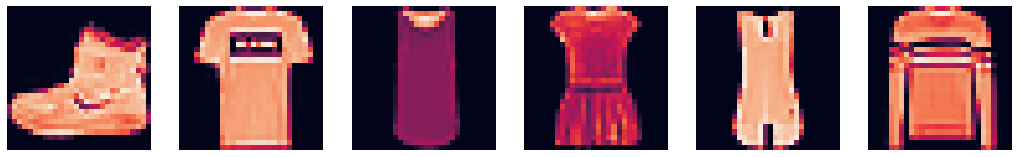

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(18,3))
for i in range(0,6):
  # convert to unsigned integers
  image = X_train[i,:,:]
 
  # plot image
  ax[i].imshow(image)
  ax[i].axis('off')

<font face="vazir" size="5">
تمیزکاری، نرمال‌سازی و آماده‌سازی دیتاست

In [5]:
X_train = X_train/255.
X_test = X_test/255.

In [6]:
# First, let's separate the target column, price
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
enc.fit(y_train)

y_train_enc = enc.transform(y_train)

In [7]:
y_test_enc = enc.transform(y_test)

In [8]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,          # minimium amount of change to be considered an improvement
    patience=5,              # number of epochs to wait before deciding there is no significant improvement in training
    restore_best_weights=True,
)

In [9]:
no_epochs = 30
batch_size = 128

In [10]:
#@title
def plot_history(history,plot_type: str='loss'):
  hist_df = pd.DataFrame(history.history)
  plt.figure(figsize=(20,8))
  colors = []
  columns_to_plot = []
  labels = []
  for col_name in hist_df.columns:

    # Define colors    
    if 'val' in col_name:
      validation = True
      color_base = 'r'
      label_base = 'Validation'
    else:
      validation = False
      color_base = 'b'
      label_base = 'Training'
    
    if plot_type == 'loss':
      if 'loss' in col_name:
        labels.append(label_base)
        columns_to_plot.append(col_name)
        colors.append(color_base)
    else:
      if 'loss' in col_name:
        continue
      if 'recall' in col_name:
        color = color_base + '--'
        label = label_base + 'Recall'
      else:
        color = color_base
        label = label_base + 'Precision'
      
      labels.append(label)
      columns_to_plot.append(col_name)
      colors.append(color)

    

  for itr in range(0,len(columns_to_plot)):
    plt.plot(hist_df.loc[:, [columns_to_plot[itr]]], colors[itr], label=labels[itr],lw=4)
  
  plt.ylabel(plot_type)
  plt.xlabel('Epochs')
  plt.legend(loc="best")

  plt.show()

### Dense Autoencoders

In [11]:
latent_space_dim = 30

In [12]:
# The encoder part
encoder = Sequential()
encoder.add(Input(shape=X_train.shape[1:]))
encoder.add(Flatten())
encoder.add(Dense(100, activation="relu"))
encoder.add(Dense(latent_space_dim, activation="relu"))

In [13]:
# The decoder part
decoder = encoder
decoder.add(Dense(100, activation="relu"))
decoder.add(Dense(X_train.shape[1] * X_train.shape[2] , activation="sigmoid"))
decoder.add(Reshape(X_train.shape[1:]))

In [14]:
model = decoder

In [15]:
from tensorflow.keras.losses import MeanSquaredError
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95),
              loss=MeanSquaredError(),
             )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 784)               79184     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 163,814
Trainable params: 163,814
Non-trai

In [17]:
history = model.fit(
      x=X_train,
      y=X_train,
      validation_data=(X_test,X_test), 
      callbacks=[early_stopping],
      verbose=1,
      epochs=no_epochs,
      batch_size=batch_size,
)

Epoch 1/30
469/469 [==============================] - 8s 14ms/step - loss: 0.0378 - val_loss: 0.0206
Epoch 2/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 3/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 4/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0150 - val_loss: 0.0146
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 7/30
469/469 [==============================] - 5s 11ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 8/30
469/469 [==============================] - 6s 14ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 9/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 10/30
469/469 [==============================] - 7s 14ms/step - loss: 0.0123 - val_loss

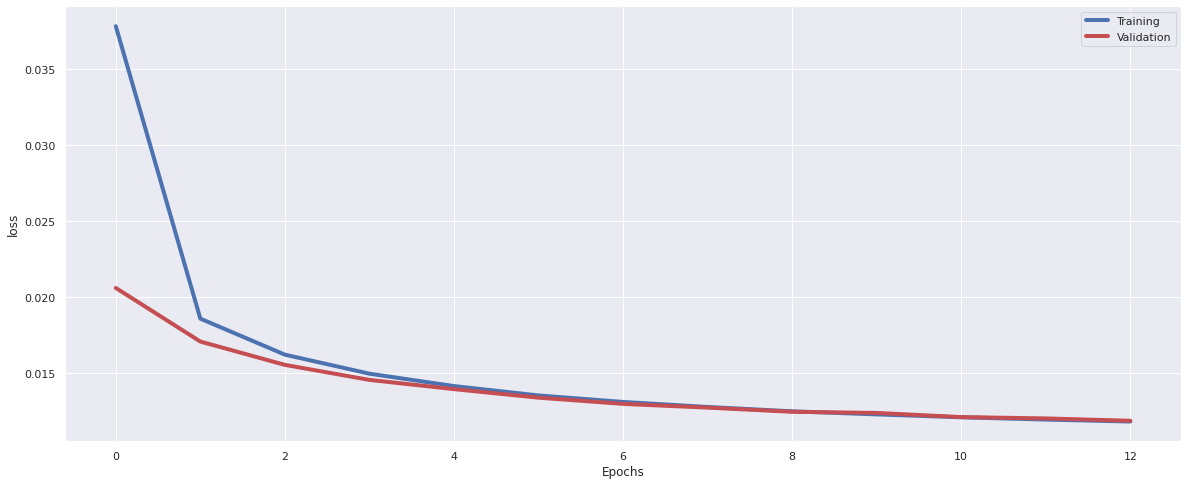

In [18]:
plot_history(history,plot_type='loss')

In [19]:
def plot_sample_output(model,input_dataset=X_test):
  fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(24,6))
  for i in range(0,8):
    # convert to unsigned integers
    image = input_dataset[i,:,:]
    pred = model.predict(np.expand_dims(image, axis=0))

    # plot image
    ax[0,i].imshow(image)
    ax[0,i].axis('off')

    ax[1,i].imshow(pred.reshape(input_dataset.shape[1:]))
    ax[1,i].axis('off')

1/1 [==============================] - 0s 16ms/step


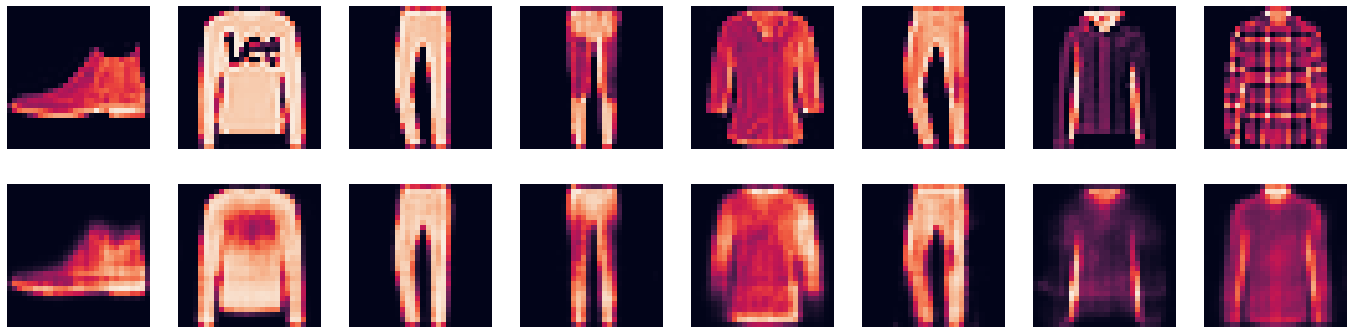

In [20]:
plot_sample_output(model)

### Convoltuional AutoEncoder

In [21]:
# The encoder part
encoder = Sequential()
encoder.add(Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu",input_shape=(28,28,1)))
encoder.add(MaxPooling2D(pool_size=2, padding="same"))
encoder.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
encoder.add(MaxPooling2D(pool_size=2, padding="same"))

In [22]:
encoder.build()
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


In [23]:
decoder = encoder
decoder.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="same",activation="relu"))
decoder.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",activation="sigmoid"))
#decoder.add(Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",activation="sigmoid"))
decoder.add(Reshape([28, 28]))

In [24]:
model = decoder
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95),
              loss='binary_crossentropy', #MeanSquaredError()
             )

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248      
 nspose)                                                         
                                                      

In [26]:
history = model.fit(
      x=X_train,
      y=X_train,
      validation_data=(X_test,X_test), 
      callbacks=[early_stopping],
      verbose=1,
      epochs=no_epochs,
      batch_size=batch_size,
)

Epoch 1/30
469/469 [==============================] - 48s 100ms/step - loss: 0.3309 - val_loss: 0.2782
Epoch 2/30
469/469 [==============================] - 46s 99ms/step - loss: 0.2713 - val_loss: 0.2699
Epoch 3/30
469/469 [==============================] - 46s 99ms/step - loss: 0.2653 - val_loss: 0.2654
Epoch 4/30
469/469 [==============================] - 46s 99ms/step - loss: 0.2619 - val_loss: 0.2627
Epoch 5/30
469/469 [==============================] - 49s 105ms/step - loss: 0.2596 - val_loss: 0.2610
Epoch 6/30
469/469 [==============================] - 48s 103ms/step - loss: 0.2581 - val_loss: 0.2597
Epoch 7/30
469/469 [==============================] - 47s 99ms/step - loss: 0.2571 - val_loss: 0.2588
Epoch 8/30
469/469 [==============================] - 46s 99ms/step - loss: 0.2563 - val_loss: 0.2580
Epoch 9/30
469/469 [==============================] - 47s 99ms/step - loss: 0.2556 - val_loss: 0.2574
Epoch 10/30
469/469 [==============================] - 47s 100ms/step - loss: 0

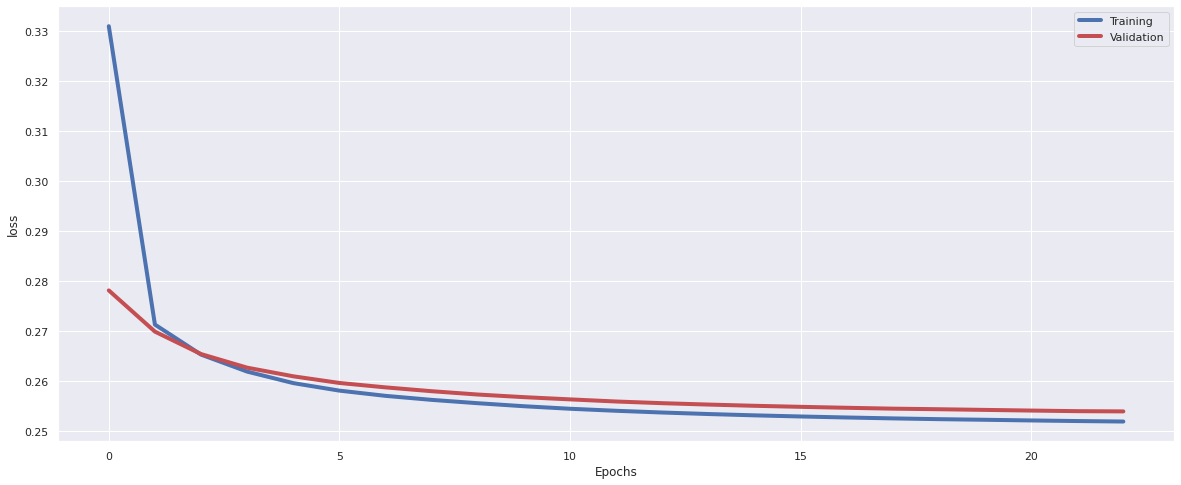

In [27]:
plot_history(history,plot_type='loss')

1/1 [==============================] - 0s 21ms/step


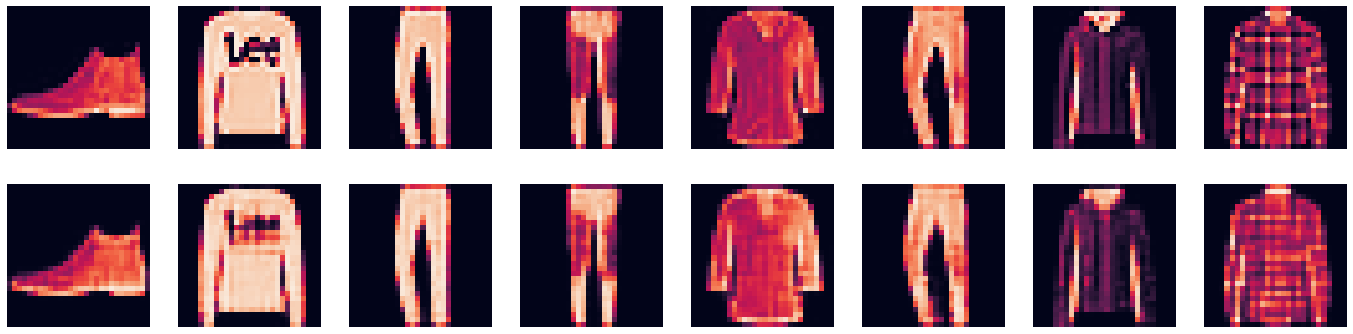

In [28]:
plot_sample_output(model)

### Denoising Autoencoders

In [29]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [30]:
# Create a copy of the data with added noise
noisy_train_data = noise(X_train)
noisy_test_data = noise(X_test)

In [31]:
history = model.fit(
      x=noisy_train_data,
      y=X_train,
      validation_data=(noisy_test_data,X_test), 
      callbacks=[early_stopping],
      verbose=1,
      epochs=no_epochs,
      batch_size=batch_size,
)

Epoch 1/30
469/469 [==============================] - 48s 101ms/step - loss: 0.2711 - val_loss: 0.2700
Epoch 2/30
469/469 [==============================] - 47s 101ms/step - loss: 0.2673 - val_loss: 0.2690
Epoch 3/30
469/469 [==============================] - 47s 101ms/step - loss: 0.2667 - val_loss: 0.2685
Epoch 4/30
469/469 [==============================] - 51s 108ms/step - loss: 0.2663 - val_loss: 0.2683
Epoch 5/30
469/469 [==============================] - 47s 101ms/step - loss: 0.2661 - val_loss: 0.2681
Epoch 6/30
469/469 [==============================] - 48s 102ms/step - loss: 0.2659 - val_loss: 0.2678
Epoch 7/30
469/469 [==============================] - 48s 102ms/step - loss: 0.2658 - val_loss: 0.2677
Epoch 8/30
469/469 [==============================] - 48s 102ms/step - loss: 0.2656 - val_loss: 0.2676


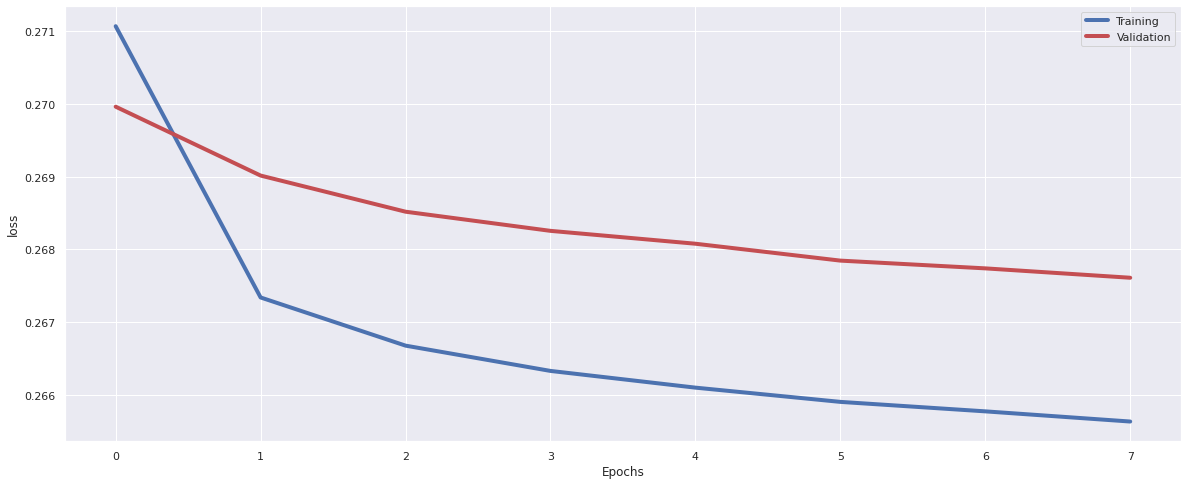

In [32]:
plot_history(history,plot_type='loss')

1/1 [==============================] - 0s 20ms/step


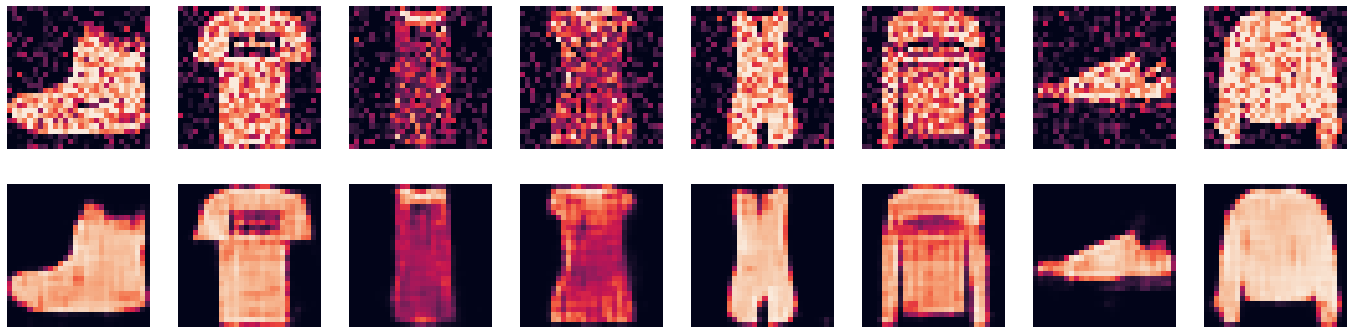

In [33]:
plot_sample_output(model,input_dataset=noisy_train_data)

# Generative Adversarial Networks (GANs)


In [34]:
image_size = X_train.shape[1]
latent_dim = 50
generator_in_channels = latent_dim 
discriminator_in_channels = 1   # 1 for black and white images, 3 for colored images

In [35]:
generator = Sequential()
generator.add(Input(generator_in_channels,)) # We want to generate generator_in_channels coefficients to reshape into a # 8x8xgenerator_in_channels map.
generator.add(Dense(7 * 7 * generator_in_channels))#,activation="selu"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Reshape((7, 7, generator_in_channels)))
generator.add(Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))#,activation="selu"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2DTranspose(latent_dim, (4, 4), strides=(2, 2), padding="same"))#,activation="selu"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(1, (7, 7), padding="same", activation="sigmoid"))

In [36]:
generator.build()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2450)              124950    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2450)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 50)          0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 50)       40050     
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 50)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 50)       40050     
 ranspose)                                            

In [37]:
discriminator = Sequential()
discriminator.add(Input((image_size, image_size, discriminator_in_channels)))
discriminator.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))#,activation="selu"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))#,activation="selu"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

In [38]:
discriminator.build()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout (Dropout)           (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                

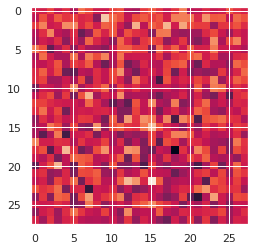

In [39]:
noise = tf.random.normal([1, generator_in_channels])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0])

In [40]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.04685985]], shape=(1, 1), dtype=float32)


In [41]:
# from_logits = True means that the values are not necessarily scaled to be between [0,1]
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss


In [42]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss

In [43]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### The optimizers

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9)

#### Adjust dataset



In [45]:
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(512).batch(batch_size)

In [46]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      # Generate the image
      generated_images = generator(noise, training=True)

      # Train dsicriminator on real images 
      real_output = discriminator(images, training=True)
      
      # Train dsicriminator on fake images 
      fake_output = discriminator(generated_images, training=True)

      # Calculate the loss for generator and discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Claculate the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update the weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [47]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 2))
  #pdb.set_trace()
  for i in range(predictions.shape[0]):
      plt.subplot(2, 4, i+1)
      
      plt.imshow(predictions[i, :, :, 0] * 255, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [48]:
import time
from IPython import display

num_examples_to_generate = 8

# The noise vector to feed the network
seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [49]:
epochs = 30

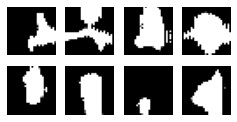

Time for epoch 1 is 792.4510509967804 sec


KeyboardInterrupt: ignored

In [50]:
if 1:#def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#### Animating the Result


In [51]:
anim_file = 'dcgan.gif'
import imageio
import glob
images = []
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    images.append(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [52]:
# Adjust the frame rate for better visualization
imageio.mimsave(anim_file,images,fps=2)


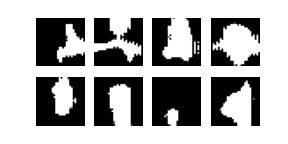

In [53]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [54]:
from google.colab import files
files.download(anim_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Explainable AI

In [55]:
# The encoder part
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.95),
              loss='categorical_crossentropy', #MeanSquaredError()
              metrics=['accuracy'],
             )
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1568)              0         
                                                                 
 dense_6 (Dense)             (None, 10)               

In [57]:
history = model.fit(X_train, y_train_enc, 
                    batch_size = 16, 
                    epochs = 15, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.5618 - accuracy: 0.8004 - val_loss: 0.4131 - val_accuracy: 0.8536
Epoch 2/15
3000/3000 [==============================] - 50s 17ms/step - loss: 0.3846 - accuracy: 0.8628 - val_loss: 0.3671 - val_accuracy: 0.8705
Epoch 3/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.3456 - accuracy: 0.8782 - val_loss: 0.3532 - val_accuracy: 0.8727
Epoch 4/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.3193 - accuracy: 0.8856 - val_loss: 0.3149 - val_accuracy: 0.8888
Epoch 5/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.2987 - accuracy: 0.8932 - val_loss: 0.3082 - val_accuracy: 0.8941
Epoch 6/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.2839 - accuracy: 0.8976 - val_loss: 0.2914 - val_accuracy: 0.8967
Epoch 7/15
3000/3000 [==============================] - 42s 14ms/step - loss: 0.2716 - accuracy: 0.9031 - val_loss: 0.2889 -

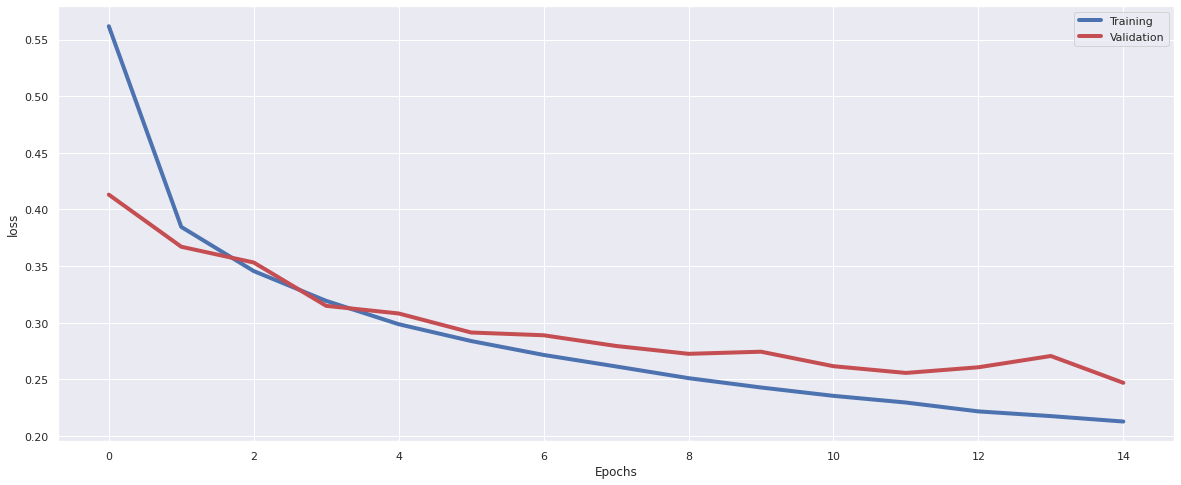

In [58]:
plot_history(history,plot_type='loss')

In [59]:
predictions = model.predict(X_test)

313/313 [==============================] - 2s 7ms/step


In [60]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

In [61]:
from sklearn.metrics import f1_score
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

Weighted F1-score is 0.91


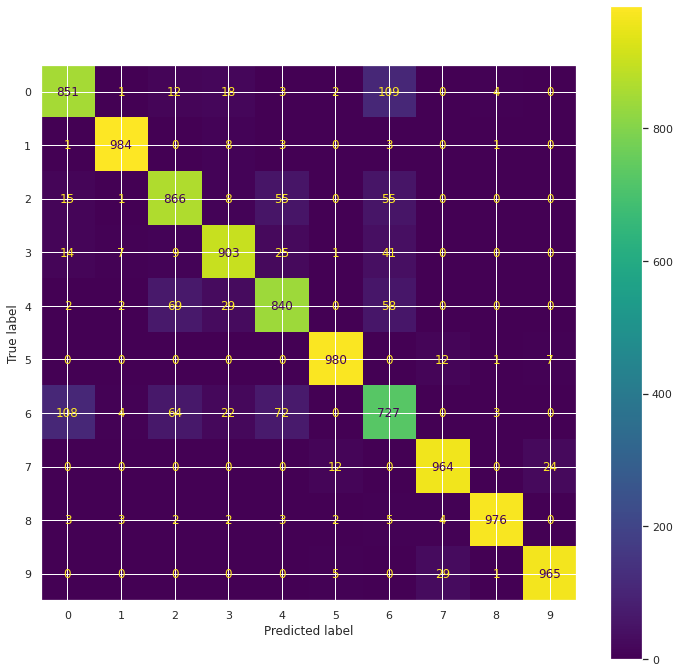

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

### Grad-CAM

In [63]:
errors_inds = np.nonzero(y_test != convert_predictions(predictions))[0]

In [64]:
img_ind = errors_inds[5]
to_predict_image = X_test[img_ind,:,:]

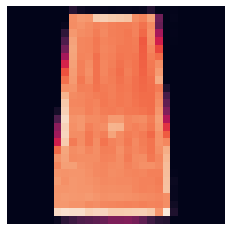

In [65]:
plt.imshow(to_predict_image)
plt.axis('off')
plt.show()

In [66]:
to_predict_image = np.expand_dims(to_predict_image, axis=0)
preds = model.predict(to_predict_image)
print("Predicted digit is:", convert_predictions(preds)[0])

1/1 [==============================] - 0s 18ms/step
Predicted digit is: 0


In [67]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [68]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(to_predict_image, model, 'conv2d_6')

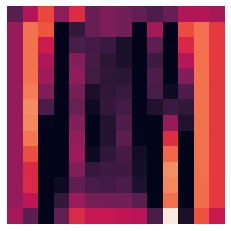

In [69]:
# Display heatmap
plt.imshow(heatmap)
plt.axis('off')
plt.show()

In [70]:
heatmap.shape

(14, 14)

In [71]:
from scipy.ndimage import zoom
heatmap_resized = zoom(heatmap,2) #upsample image


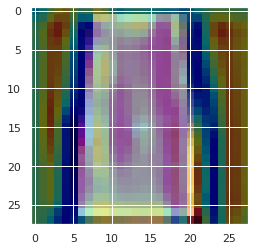

In [72]:
plt.imshow(to_predict_image[0,:,:])
plt.imshow(heatmap_resized, cmap='jet', alpha=0.4)
plt.show()

### LIME

In [73]:
import tensorflow as tf    
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [74]:
# This line is necessary to use SHAP with current version of TF in Colab
tf.compat.v1.disable_v2_behavior()    

Instructions for updating:
non-resource variables are not supported in the long term


In [75]:
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

In [76]:
X_train_rgb = to_rgb(X_train.reshape((-1,28,28,1)).astype('float32') / 255.0)
X_test_rgb = to_rgb(X_test.reshape((-1,28,28,1)).astype('float32') / 255.0)

In [77]:
# The encoder part
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu",input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95),
              loss='categorical_crossentropy', #MeanSquaredError()
              metrics=['accuracy'],
             )
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_7 (Dense)             (None, 10)               

In [78]:
history = model.fit(X_train_rgb, y_train_enc, 
                    batch_size = 16, 
                    epochs = 15, 
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
47968/48000 [============================>.] - ETA: 0s - loss: 0.7678 - acc: 0.7242

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 40s 840us/sample - loss: 0.7676 - acc: 0.7242 - val_loss: 0.5438 - val_acc: 0.8014
Epoch 2/15
48000/48000 [==============================] - 40s 835us/sample - loss: 0.5069 - acc: 0.8170 - val_loss: 0.4769 - val_acc: 0.8239
Epoch 3/15
48000/48000 [==============================] - 40s 836us/sample - loss: 0.4479 - acc: 0.8391 - val_loss: 0.4387 - val_acc: 0.8388
Epoch 4/15
48000/48000 [==============================] - 43s 898us/sample - loss: 0.4197 - acc: 0.8515 - val_loss: 0.4109 - val_acc: 0.8548
Epoch 5/15
48000/48000 [==============================] - 40s 839us/sample - loss: 0.3987 - acc: 0.8581 - val_loss: 0.4086 - val_acc: 0.8537
Epoch 6/15
48000/48000 [==============================] - 40s 837us/sample - loss: 0.3837 - acc: 0.8631 - val_loss: 0.3909 - val_acc: 0.8622
Epoch 7/15
48000/48000 [==============================] - 43s 902us/sample - loss: 0.3710 - acc: 0.8679 - val_loss: 0.3685 - val_acc: 0.8688
Epoch 8/15
48000/48000 [

In [79]:
predictions = model.predict(X_test_rgb)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Weighted F1-score is 0.88


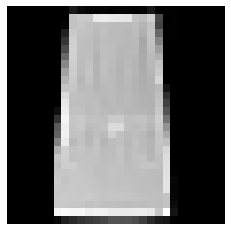

In [80]:
errors_inds = np.nonzero(y_test != convert_predictions(predictions))[0]
img_ind = errors_inds[4]
to_predict_image = X_test_rgb[img_ind,:,:,:]
plt.imshow(255*to_predict_image)
plt.axis('off')
plt.show()

In [81]:
to_predict_image = np.expand_dims(to_predict_image, axis=0)
preds = model.predict(to_predict_image)
print("Predicted digit is:", convert_predictions(preds)[0])
print("Actual label is:", y_test[img_ind])

Predicted digit is: 0
Actual label is: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

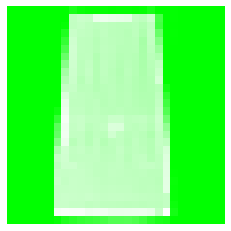

In [82]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(to_predict_image[0,:,:,:], model.predict)
plt.imshow(to_predict_image[0])


image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
         positive_only=False, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask)*255)
plt.axis('off')
plt.show()

###SHAP

In [83]:
import shap

In [84]:
explainer = shap.DeepExplainer(model, X_train_rgb[0:100,:,:,:])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [85]:
shap_values = explainer.shap_values(to_predict_image)

In [86]:
true_label = y_test[img_ind]
predicted_label = convert_predictions(preds)[0]

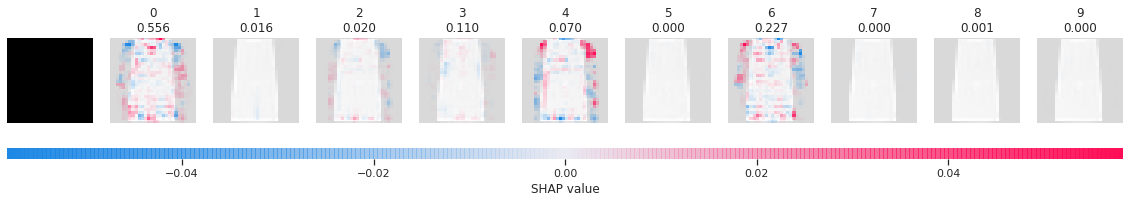

In [87]:
index_names = []
for x in range(10):
  index_names.append(str(x) + '\n' + '%0.3f' %preds[0][x])

    
#Displays the results.
shap.image_plot(shap_values, to_predict_image ,index_names ,show=False)
plt.show()

### Eli5

In [88]:
import eli5
from IPython.display import display
from PIL import Image

In [89]:
expl = eli5.explain_prediction(model, 255*to_predict_image, targets=[int(predicted_label)])

In [90]:
print(expl)

Explanation(estimator='<keras.engine.sequential.Sequential object at 0x7f16abf4f1f0>', description=None, error='estimator <keras.engine.sequential.Sequential object at 0x7f16abf4f1f0> is not supported', method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)


In [91]:
preds_sorted = -np.sort(-preds)
digits = np.argsort(-preds)

TypeError: ignored

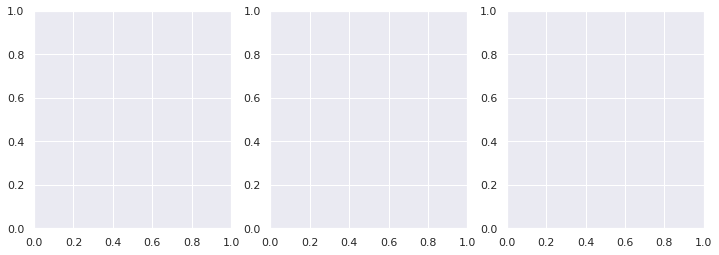

In [93]:
# Plot the explanation for the top 3 classes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for i in range(3):

  # Create the explanation class
  expl = eli5.explain_prediction(model, 255*to_predict_image, targets=[int(digits[0][i])])

  # Get the image and corresponding heatmap
  image = expl.image
  heatmap = expl.targets[0].heatmap

  # Resize the heatmap to the size of the image (per GradCAM's approach)
  heatmap_im = eli5.formatters.image.expand_heatmap(heatmap, image, resampling_filter=Image.BOX)
  
  # Display the results
  ax[i].imshow(image)
  ax[i].imshow(heatmap_im, cmap='jet', alpha=0.4)
  ax[i].title.set_text('Digit: %d, prob: %.3f' %(digits[0][i],preds_sorted[0][i]))
  ax[i].axis('off')
